# Cargo Theft Data Clustering
## Import and Trim a Little More

In [1]:
# Start with magic
%matplotlib inline

# Import the necessary dependencies.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
# Get the Crime Report data.
df = pd.read_csv("Datasets/CrimeReport.csv")
df.head()

,data_year,pub_agency_name,agency_type_name,state_name,division_name,county_name,region_name,population_group_code,population_group_desc,offense_code,...,location_code,location_name,weapon_code,weapon_name,prop_desc_code,prop_desc_name,stolen_value,recovered_value,recovered_flag,date_recovered
0,2021,Angelina,County,Texas,West South Central,ANGELINA,South,8B,"Non-MSA counties from 25,000 thru 99,999",26B,...,25,Other/Unknown,95,Unknown,20,Money,375.0,0,False,NaN
1,2021,Jefferson,County,Alabama,East South Central,JEFFERSON,South,9A,"MSA counties 100,000 or over",23H,...,20,Residence/Home,95,Unknown,77,Other,1.0,0,False,NaN
2,2021,Jefferson,County,Alabama,East South Central,JEFFERSON,South,9A,"MSA counties 100,000 or over",23H,...,20,Residence/Home,95,Unknown,65,Identity Documents,0.0,0,False,NaN
3,2021,Jefferson,County,Alabama,East South Central,JEFFERSON,South,9A,"MSA counties 100,000 or over",23H,...,20,Residence/Home,95,Unknown,13,Firearms,320.0,0,False,NaN
4,2021,Jefferson,County,Alabama,East South Central,JEFFERSON,South,9A,"MSA counties 100,000 or over",23F,...,20,Residence/Home,95,Unknown,77,Other,1.0,0,False,NaN


In [3]:
# The dates, the agency, the offender, and the weapon will not be factored into this.
# The state is favored as the middle between the county and the region/division.
# Thus, these shall all be dropped.
dropped = ["data_year", "pub_agency_name", "agency_type_name",
           "division_name", "county_name", "region_name",
           "offender_race", "offender_ethnicity", "offender_age",
           "offender_sex", "weapon_code", "weapon_name", "date_recovered"]
df0 = df.drop(columns = dropped, axis = 1)
df0.head()

,state_name,population_group_code,population_group_desc,offense_code,offense_name,victim_type_code,victim_type_name,location_code,location_name,prop_desc_code,prop_desc_name,stolen_value,recovered_value,recovered_flag
0,Texas,8B,"Non-MSA counties from 25,000 thru 99,999",26B,Credit Card/Automated Teller Machine Fraud,I,Individual,25,Other/Unknown,20,Money,375.0,0,False
1,Alabama,9A,"MSA counties 100,000 or over",23H,All Other Larceny,I,Individual,20,Residence/Home,77,Other,1.0,0,False
2,Alabama,9A,"MSA counties 100,000 or over",23H,All Other Larceny,I,Individual,20,Residence/Home,65,Identity Documents,0.0,0,False
3,Alabama,9A,"MSA counties 100,000 or over",23H,All Other Larceny,I,Individual,20,Residence/Home,13,Firearms,320.0,0,False
4,Alabama,9A,"MSA counties 100,000 or over",23F,Theft From Motor Vehicle,I,Individual,20,Residence/Home,77,Other,1.0,0,False


## I. First Selection - The Stolen Values of Objects as a Whole

In [4]:
# Set up the DataFrame.
stolen_df = df0[["state_name", "population_group_code", "offense_code", "victim_type_code",
                 "location_code", "prop_desc_code", "stolen_value"]]
stolen_df.head()

,state_name,population_group_code,offense_code,victim_type_code,location_code,prop_desc_code,stolen_value
0,Texas,8B,26B,I,25,20,375.0
1,Alabama,9A,23H,I,20,77,1.0
2,Alabama,9A,23H,I,20,65,0.0
3,Alabama,9A,23H,I,20,13,320.0
4,Alabama,9A,23F,I,20,77,1.0


In [5]:
# Null values should have been dealt with, but are there any duplicates again?
stolen_df.duplicated().sum()

24697

In [6]:
# Deal with the duplicates.
stolen_df.drop_duplicates()

,state_name,population_group_code,offense_code,victim_type_code,location_code,prop_desc_code,stolen_value
0,Texas,8B,26B,I,25,20,375.0
1,Alabama,9A,23H,I,20,77,1.0
2,Alabama,9A,23H,I,20,65,0.0
3,Alabama,9A,23H,I,20,13,320.0
4,Alabama,9A,23F,I,20,77,1.0
...,...,...,...,...,...,...,...
122951,Florida,9A,23F,B,25,37,10000.0
122952,Florida,9A,23F,B,25,36,35.0
122953,South Carolina,9A,240,B,18,78,20000.0
122954,Tennessee,1B,23F,B,7,2,32.0


## II. Second Selection - Look at the Recovered Subset

In [7]:
# Set up the DataFrame.
recov_df = df0.loc[df0.recovered_flag == True][["state_name", "population_group_code", "offense_code",
                                                "victim_type_code", "location_code", "prop_desc_code",
                                                "stolen_value", "recovered_value"]]
recov_df.head()

,state_name,population_group_code,offense_code,victim_type_code,location_code,prop_desc_code,stolen_value,recovered_value
16,Alabama,9B,23H,I,20,9,0.0,0
42,West Virginia,9A,23H,I,25,77,5000.0,5000
46,Alabama,2,240,I,20,3,12000.0,12000
49,Alabama,2,240,I,20,3,11000.0,11000
66,Alabama,2,240,I,18,3,20000.0,20000


In [8]:
# Find the recovery percentage.
recov_df["recovery_rate"] = np.where(recov_df.stolen_value > 0,
                                     recov_df.recovered_value / recov_df.stolen_value, 0)
recov_df.head()

,state_name,population_group_code,offense_code,victim_type_code,location_code,prop_desc_code,stolen_value,recovered_value,recovery_rate
16,Alabama,9B,23H,I,20,9,0.0,0,0.0
42,West Virginia,9A,23H,I,25,77,5000.0,5000,1.0
46,Alabama,2,240,I,20,3,12000.0,12000,1.0
49,Alabama,2,240,I,20,3,11000.0,11000,1.0
66,Alabama,2,240,I,18,3,20000.0,20000,1.0


In [9]:
# Null values should have been dealt with, but are there any duplicates again?
recov_df.duplicated().sum()

4239

In [10]:
# Deal with the duplicates.
recov_df.drop_duplicates()

,state_name,population_group_code,offense_code,victim_type_code,location_code,prop_desc_code,stolen_value,recovered_value,recovery_rate
16,Alabama,9B,23H,I,20,9,0.0,0,0.0
42,West Virginia,9A,23H,I,25,77,5000.0,5000,1.0
46,Alabama,2,240,I,20,3,12000.0,12000,1.0
49,Alabama,2,240,I,20,3,11000.0,11000,1.0
66,Alabama,2,240,I,18,3,20000.0,20000,1.0
...,...,...,...,...,...,...,...,...,...
122938,South Carolina,7,23F,B,18,7,3000.0,3000,1.0
122944,Florida,9A,240,B,0,37,10000.0,10000,1.0
122951,Florida,9A,23F,B,25,37,10000.0,10000,1.0
122953,South Carolina,9A,240,B,18,78,20000.0,20000,1.0


## Ready and Run the PCA

In [11]:
# Use get_dummies() to handle the categorical features.
features = ["state_name", "population_group_code", "offense_code", "victim_type_code"]
X_stolen = pd.get_dummies(stolen_df, columns = features)
X_recov = pd.get_dummies(recov_df, columns = features)

print(X_stolen.shape)
print(X_recov.shape)

(122956, 101)
(17281, 97)


In [12]:
# Standardize the data with StandardScaler().
stolenX_scaled = StandardScaler().fit_transform(X_stolen)
recovX_scaled = StandardScaler().fit_transform(X_recov)

In [13]:
# Use PCA to reduce the stolen values DataFrame to three principal components.
pca = PCA(n_components = 3, random_state = 0) # Use Random State of 0 for this one.
pca_stolen = pca.fit_transform(stolenX_scaled)

# Put the results into a DataFrame.
stolenpca_df = pd.DataFrame(data = pca_stolen, columns = ["PC 1", "PC 2", "PC 3"], index = X_stolen.index)
print(stolenpca_df.shape)
stolenpca_df.head(10)

(122956, 3)


,PC 1,PC 2,PC 3
0,-0.605419,1.346002,-0.177242
1,-0.970620,0.040110,1.038980
2,-0.969996,0.044291,1.007054
3,-0.967286,0.062410,0.868717
4,-1.240702,-0.531430,-0.564752
5,-1.240078,-0.527249,-0.596677
6,-1.237368,-0.509130,-0.735014
7,-1.119465,0.658702,0.598656
8,-1.119000,0.661838,0.574705
9,-1.129937,0.034804,-0.410309


In [14]:
# Use PCA to reduce the recovered values DataFrame to three principal components.
pca_recov = pca.fit_transform(recovX_scaled)

# Put the results into a DataFrame.
recovpca_df = pd.DataFrame(data = pca_recov, columns = ["PC 1", "PC 2", "PC 3"], index = X_recov.index)
print(recovpca_df.shape)
recovpca_df.head(10)

(17281, 3)


,PC 1,PC 2,PC 3
16,-1.051555,0.394574,0.473535
42,-0.520877,0.127223,1.170733
46,-0.757839,0.692213,-1.503862
49,-0.762056,0.686654,-1.503839
66,-0.712609,0.733277,-1.500948
83,1.283008,-0.748417,0.440788
87,1.420841,-0.523232,-0.983288
91,-0.706011,0.374155,0.182528
95,-0.568178,0.599340,-1.241548
104,-0.425182,0.200840,0.669516


## Cluster the Data with K-Means

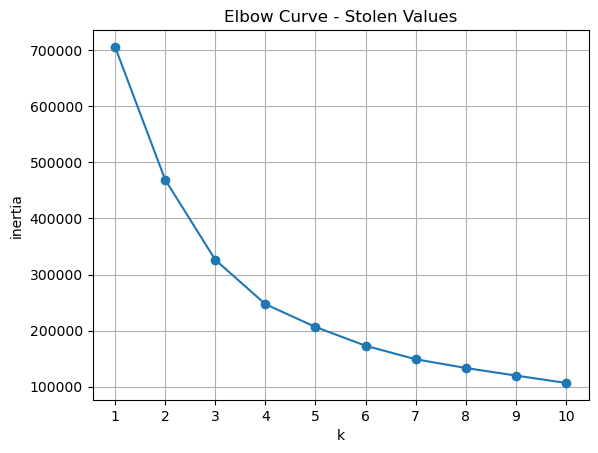

In [15]:
# Create an elbow curve to find the best value for K.
inertia = []
K = list(range(1, 11))
for i in K:
    kmeanmodel = KMeans(n_clusters = i, random_state = 1).fit(stolenpca_df)
    inertia.append(kmeanmodel.inertia_)

# Plot
fig, ax = plt.subplots()

ax.plot(K, inertia, "o-")

ax.set(xlabel = "k", ylabel = "inertia", title = "Elbow Curve - Stolen Values")

ax.grid()

ax.set_xticks(K)

plt.show()

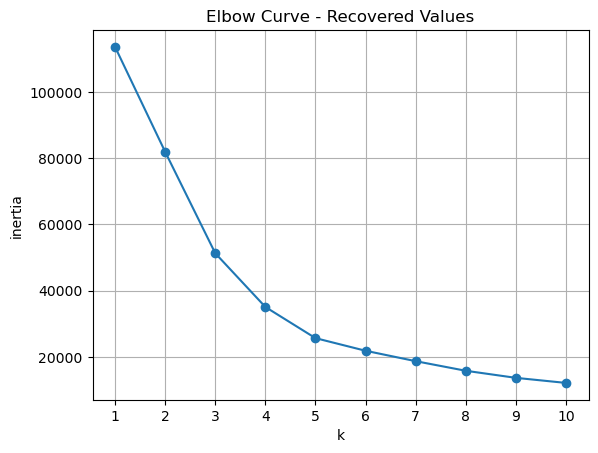

In [16]:
# Do this again with the other DataFrame.
inertia = []
K = list(range(1, 11))
for i in K:
    kmeanmodel = KMeans(n_clusters = i, random_state = 1).fit(recovpca_df)
    inertia.append(kmeanmodel.inertia_)

# Plot
fig, ax = plt.subplots()

ax.plot(K, inertia, "o-")

ax.set(xlabel = "k", ylabel = "inertia", title = "Elbow Curve - Recovered Values")

ax.grid()

ax.set_xticks(K)

plt.show()